# Comparison of VCF files

## 1. Introduction

The goal of this assignment is to do variant calling on human_g1k_v37_decoy.fasta reference genome and C835.HCC1143.2.converted.realigned.base_recalibrated.bam file using two callers: GATK 4 HaplotypeCaller [1] and FreeBayes [2].

After that, results need to be compared using HaplotypeCaller's one as a truth set and Freebayes' one as a test set. Informations of interest are: number of true positives, false positives and false negatives, precision, recall and f-score.

## 2. Variant calling

In order to do variant calling with GATK 4 HaplotypeCaller, two input arguments are required: input alingments (BAM file) and reference (FASTA file). Apart from those, two additional files need to be present in the directory with reference files, with FAI and DICT formats. Results are written into gatk_result.vcf, and this will be considered the truth set of further analysis.

FreeBayes also requires same arguments as previous caller, but it does not require any additional files to be present. Results are written into freebayes_result.freebayes.vcf, which will be test set of further analysis.

## 3. VCF comparison

VCF is a text file format that contains meta-information lines, a headerline, and then data lines each containing information about a position in the genome. The format also has the ability to contain genotype information on samples for each position. [3] It is the format in which the results of both previously used tools were written.

True positive variants are those varients from the test set that are also present in the truth set, while false positive are the ones that aren't presnt in the truth set. On the other hand, false negatives are those variants present in the thruth set, but missing from the test set. Precision, in this particular context, is fraction of true positive varients in the test set, while recall is fraction of true poositive varients in the truth set. F-measure is the harmonic mean of precision and recal.

### 3.1. Simple algorithm

The most simple way of comparing VCF files would be to compare only chromosome names in wich variants are found, their positions within chromosomes, as well as reference and alt alleles.

To read VCF `pysam` Python module [5] will be used, specificaly its `VariantFile` class.

In [14]:
import pysam

truthSet = pysam.VariantFile("vcf_files/gatk_result.vcf")
testSet = pysam.VariantFile("vcf_files/freebayes_result.freebayes.vcf")

The number of varients in each file can now be obtained.

In [2]:
truthSet.reset()
testSet.reset()

truthCount = len(list(truthSet))
testCount = len(list(testSet))

print(f"Number of variants in truth set: {truthCount}")
print(f"Number of variants in test set: {testCount}")

Number of variants in truth set: 70181
Number of variants in test set: 77620


Now is the time to check if variants in files are in order or not. But, before that, since chromosome name is a string, it needs to be transformed into integer, which is comparable using lesser and greater than. Easiest way to do this is using dictionaries.

In [3]:
chromDict = {
    "1": 1, "2": 2, "3": 3, "4": 4, "5": 5, "6": 6, "7": 7, "8": 8, "9": 9, "10": 10,
    "11": 11, "12": 12, "13": 13, "14": 14, "15": 15, "16": 16, "17": 17, "18": 18,
    "19": 19, "20": 20, "21": 21, "22": 22, "X": 23, "Y": 24, "MT": 25
}

truthTest = True
testTest = True

truthSet.reset()
testSet.reset()

prevRecord = next(truthSet)

for record in truthSet:
    if chromDict[prevRecord.chrom] > chromDict[record.chrom] or (chromDict[prevRecord.chrom] == chromDict[record.chrom] and prevRecord.pos > record.pos):
        truthTest = False
        break
    
    prevRecord = record

prevRecord = next(testSet)

for record in testSet:
    if chromDict[prevRecord.chrom] > chromDict[record.chrom] or (chromDict[prevRecord.chrom] == chromDict[record.chrom] and prevRecord.pos > record.pos):
        testTest = False
        break
    
    prevRecord = record

print("Truth set: " + "IN ORDER" if (truthTest) else "NOT IN ORDER")
print("Test set: " + "IN ORDER" if (testTest) else "NOT IN ORDER")

Truth set: IN ORDER
Test set: IN ORDER


Knowing that both files are in order greatly reduces analysis time, since only one pass trough both of the files is required. It is enough to look for true positives, since number false positives and false negatives can be calculated by subtracting number of true positives from total munber of varients in test set and truth set, respectively. Result can be visualiyed using `pandas` Python module [6].

,True positives,False positives,False negatives
,18955,58665,51226


,Precision,Recall,F-measure
,0.244203,0.270087,0.256494


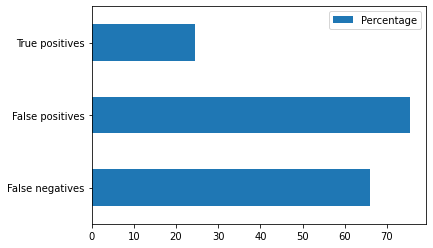

In [15]:
import pandas
import matplotlib

truePositives = 0

truthSet.reset()
testSet.reset()

testRecord = next(testSet)

for truthRecord in truthSet:
    try:
        if chromDict[truthRecord.chrom] == chromDict[testRecord.chrom]:
            if truthRecord.pos == testRecord.pos:
                if truthRecord.ref == testRecord.ref and truthRecord.alts == testRecord.alts:
                    truePositives += 1
                testRecord = next(testSet)
            elif truthRecord.pos > testRecord.pos:
                while chromDict[truthRecord.chrom] == chromDict[testRecord.chrom] and truthRecord.pos > testRecord.pos:
                    testRecord = next(testSet)
        elif chromDict[truthRecord.chrom] > chromDict[testRecord.chrom]:
            while chromDict[truthRecord.chrom] > chromDict[testRecord.chrom]:
                testRecord = next(testSet)
    except:
        break

truthSet.close()
testSet.close()

falsePositives = testCount - truePositives
falseNegatives = truthCount - truePositives

def outputData(truePositives, falsePositives, falseNegatives, truthCount, testCount):
    precision = truePositives / testCount
    recall = truePositives / truthCount
    fMeasure = 2 * precision * recall / (precision + recall)

    dataFrame1 = pandas.DataFrame([truePositives, falsePositives, falseNegatives], ["True positives", "False positives", "False negatives"], [""])

    dataFrame2 = pandas.DataFrame([precision, recall, fMeasure], ["Precision", "Recall", "F-measure"], [""])

    dataFrame3 = pandas.DataFrame([falseNegatives / testCount * 100, falsePositives / testCount * 100, truePositives/ testCount * 100], ["False negatives", "False positives", "True positives"], ["Percentage"])

    display(dataFrame1.T)
    display(dataFrame2.T)
    dataFrame3.plot.barh();

outputData(truePositives, falsePositives, falseNegatives, truthCount, testCount)

It can be seen that there is a big descrepancy between the results. This is because proposed analysis is too basic and doesn't take a lot of things into consideration. For example, these tools might format same variants in a different way, which is exactly what happend with variants on positions 889158 and 889159 in chromosome 1.

Truth set:
```
1	889158	.	G	C
1	889159	.	A	C
```
Test set:
```
1	889158	.	GA	CC
```
Fortunately, there are available tools that execute more advanced analysis.

### 3.2. BCFtools

BCFtools [7] is a program for variant calling and manipulating VCF and BCF files. Of special interest here is `bcftools isec` command, which can create intersections, unions and complements of VCF files. [8] As arguments, it requires two VCF files to compare and returns four VCF files that represent records private to first file, records private second file, records from first file shared by both and records from second file shared by both, as well as a TXT file that explains the contents of aforementioned VCF files. Therefore, only thing that needs to be done to analize the results is to count recors in these files.

,True positives,False positives,False negatives
,57835,19785,12346


,Precision,Recall,F-measure
,0.745104,0.824083,0.782606


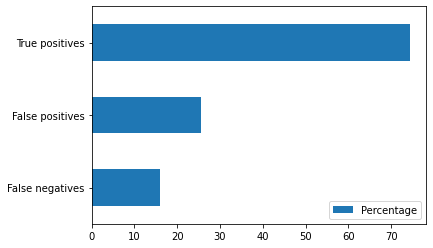

In [16]:
file0 = pysam.VariantFile("bcftools/0000.vcf")
file1 = pysam.VariantFile("bcftools/0001.vcf")
file2 = pysam.VariantFile("bcftools/0002.vcf")

truePositivesBCF = len(list(file2))
falsePositivesBCF = len(list(file0))
falseNegativesBCF = len(list(file1))

file0.close()
file1.close()
file2.close()

outputData(truePositivesBCF, falsePositivesBCF, falseNegativesBCF, truthCount, testCount)

## 5. References

[1] https://gatk.broadinstitute.org/hc/en-us

[2] https://github.com/freebayes/freebayes

[3] http://samtools.github.io/hts-specs/VCFv4.2.pdf

[4] https://en.wikipedia.org/wiki/Precision_and_recall

[5] https://github.com/pysam-developers/pysam

[6] https://pandas.pydata.org/

[7] http://samtools.github.io/bcftools/

[8] http://samtools.github.io/bcftools/howtos/index.html